In [ ]:
!pip install catboost
!pip install shap

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [634]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
import shap
import math

In [185]:
SEED = 42

In [358]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def outlier_value(df):
    z = np.abs(stats.zscore(df['price_per_sqm']))
    df1 = df.copy()
    df1['z'] = z
    return min(df1[df1['z'] > 3]['price_per_sqm'])

In [469]:
dir = 'drive/My Drive/Colab Notebooks/CSC/Projects/REZ_8/'
df = pd.read_csv(dir + 'flats.csv', index_col = 0)
str_columns = ['address', 'desc']
cat_columns = ['company', 'agent', 'renovation', 'balcony', 'view', 'bathroom', 'hot_water', 'heating', 'stove', 
               'house_type', 'elevator', 'entrance', 'parking', 'security', 'close_metro1', 'close_metro2',
               'close_railway1', 'close_railway2', 'how_selled', 'metro', 'name', 'area', 'district', 'unit']
int_columns = ['storeys', 'year_built', 'year_repaired', 'n_updates', 'first_price', 'last_price', 'owner',
               'online_display', 'top', 'up', 'color', 'day', 'warn', 'storey']
float_columns = ['total_area', 'living_area', 'kitchen_area', 'ceiling_height', 'close_metro1_dist',
                 'close_metro2_dist', 'close_railway1_dist', 'close_railway2_dist']
datetime_columns = ['first_seen', 'last_seen']
for col in str_columns:
    df[col] = df[col].astype('str')
for col in cat_columns:
    df[col] = df[col].astype('category')
for col in int_columns:
    df[col] = df[col].astype('float').astype('Int64')
for col in float_columns:
    df[col] = df[col].astype('float')
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], dayfirst = True)

In [ ]:
#sold = df[df['last_seen'] <= '2021-05-11']
#sold['time_to_sell'] = (sold['last_seen'] - sold['first_seen']).dt.days

Общий препроцессинг датасета

In [470]:
# name
df['name'] = df['name'].astype('object')
df.loc[df['name'] == 'Апартаменты-cтудия', 'name'] = '0'
df.loc[df['name'] == 'Комната в 3 ккв', 'name'] = '0'
df.loc[df['name'] == 'Студия', 'name'] = '0'
df['name'] = df['name'].str.split(expand=True)[0]
df['name'] = df['name'].astype('int')
# agent: слишком много разных агентов, закодируем просто, как есть агент или нет
df['agent'] = pd.isnull(df['agent']) == False
# address, desc: удалим эти колонки
df = df.drop(['address', 'desc'], axis = 1)
# elevator, entrance, parking, how_selled хоть и нуждаются в обработке (они представляют собой список характеристик), но не будут обрабатаны

Исправление датасета: удаление "некорректных" объявлений.

In [471]:
print('изначальное количество наблюдений:', df.shape[0])
correct = ((df['total_area'] > 1000) & (df['name'] < 4)) == False
df = df[correct]
print('кол-во наблюдений после фильтрации по общей площади:', df.shape[0])
correct = (df['total_area'] < df['living_area']) | (df['total_area'] < df['kitchen_area']) == False
df = df[correct]
print('кол-во наблюдений после фильтрации по жилой площади и кухне:', df.shape[0])
correct = (df['ceiling_height'] > 10) == False
df = df[correct]
print('кол-во наблюдений после фильтрации по высоте потолков:', df.shape[0])
correct = ((df['storey'] > df['storeys']) == False).fillna(True)
df = df[correct]
correct = ((df['storey'] > 40) == False).fillna(True)
df = df[correct]
print('кол-во наблюдений после фильтрации по этажам:', df.shape[0])
correct = ((df['year_built'] > 2021) == False).fillna(True)
df = df[correct]
correct = ((df['year_repaired'] > 2021) == False).fillna(True)
df = df[correct]
print('кол-во наблюдений после фильтрации по годам постройки и ремонта:', df.shape[0])
correct = (((df['last_price'] > 100000000) & (df['name'] < 3)) == False)
df = df[correct]
print('кол-во наблюдений после фильтрации по цене:', df.shape[0])

изначальное количество наблюдений: 24424
кол-во наблюдений после фильтрации по общей площади: 24394
кол-во наблюдений после фильтрации по жилой площади и кухне: 24391
кол-во наблюдений после фильтрации по высоте потолков: 24385
кол-во наблюдений после фильтрации по этажам: 24381
кол-во наблюдений после фильтрации по годам постройки и ремонта: 24350
кол-во наблюдений после фильтрации по цене: 24348


In [472]:
print(df.isnull().sum()/df.shape[0] > 0.75)

name                   False
area                   False
district               False
unit                   False
company                False
agent                  False
total_area             False
living_area            False
kitchen_area           False
ceiling_height         False
renovation             False
balcony                False
view                    True
bathroom               False
hot_water               True
heating                 True
stove                   True
storey                 False
storeys                False
house_type             False
year_built             False
year_repaired           True
elevator               False
entrance                True
parking                 True
security                True
close_metro1           False
close_metro1_dist      False
close_metro2           False
close_metro2_dist      False
close_railway1         False
close_railway1_dist    False
close_railway2         False
close_railway2_dist    False
how_selled    

Попытаемся решить две задачи: 
1.   Предсказание цены квартиры
2.   Предсказание времени продажи квартиры.

Обе задачи имеют практическое применение и направлены на улучшение сервиса для продавцев квартир на сайтах недвижимости. Продавцу можно подсказывать "адекватную" (относительно характеристик квартиры и существующих объявлений) цену, а также показывать приблизительное время продажи квартиры при такой цене.

1-ая задача: предсказание "адекватной" цены квартиры:

In [569]:
y = df['last_price']/df['total_area'].copy()
X = df.drop(['first_price', 'first_seen', 'last_seen', 'last_price'], axis = 1).copy()
nans_features = ['entrance', 'parking', 'security', 'heating', 'stove', 
                 'hot_water', 'view', 'year_repaired'] # features with a lot of nans > 80
X = X.drop(nans_features, axis = 1).copy() 
X['owner'] = X['owner'].astype('category')

In [570]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [571]:
cat_features = list(X.select_dtypes(['category']).columns)

In [ ]:
cat_features = list(X.select_dtypes(['category']).columns)
for cat_feature in cat_features:
    X_train[cat_feature] = X_train[cat_feature].astype('str')
    X_test[cat_feature] = X_test[cat_feature].astype('str')
for feature in set(X.columns) - set(cat_features):
    X_train[feature] = X_train[feature].astype('float')
    X_test[feature] = X_test[feature].astype('float')
y_train = y_train.astype('float')
y_test = y_test.astype('float')
model = CatBoostRegressor(cat_features=cat_features, loss_function='RMSE', iterations = 500)

In [573]:
model.fit(X_train, y_train, verbose = 200)

Learning rate set to 0.11213
0:	learn: 65745.8972064	total: 76ms	remaining: 37.9s
200:	learn: 31069.7637834	total: 11.4s	remaining: 17s
400:	learn: 25965.6921140	total: 24s	remaining: 5.92s
499:	learn: 24474.0088442	total: 30.3s	remaining: 0us


In [574]:
y_pred = model.predict(X_test)

In [577]:
mean_absolute_percentage_error(y_test, y_pred)

11.901490186684349

In [545]:
explainer = shap.TreeExplainer(model)

In [546]:
shap_values = explainer.shap_values(X_train)

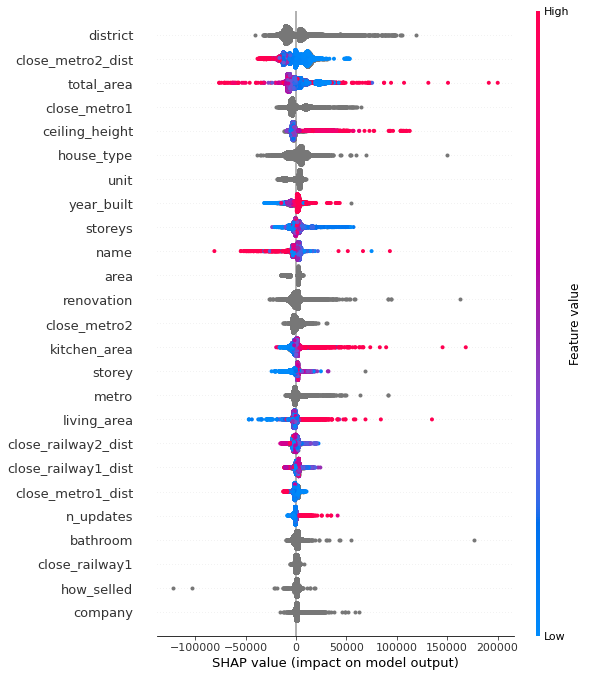

In [547]:
shap.summary_plot(shap_values, X_train, max_display = 25)

2-ая задача: предсказание времени продажи квартиры. Сведем задачу к бинарной классификации: быстро или медленно была продана квартира

Делаем смелое предположение: квартира, которая более 3 дней отсутствует на сайте - была продана

In [668]:
sold = df[df['last_seen'] <= '2021-05-15']
sold['time_to_sell'] = (sold['last_seen'] - sold['first_seen']).dt.days


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [691]:
y = sold['time_to_sell'].copy()
X = sold.drop(['first_price', 'first_seen', 'last_seen'], axis = 1).copy()
cheat_features = ['n_updates', 'online_display', 'top', 'up', 'color', 'day', 'warn']
for cheat_feature in cheat_features:
    X[cheat_feature] = X[cheat_feature]/(X['time_to_sell'] + 1)
X = X.drop(['time_to_sell'], axis = 1).copy()
nans_features = ['entrance', 'parking', 'security', 'heating', 'stove',
                 'hot_water', 'view', 'year_repaired'] # features with a lot of nans (> 0.8)
X = X.drop(nans_features, axis = 1).copy()
X['owner'] = X['owner'].astype('category')

In [692]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [693]:
cat_features = list(X.select_dtypes(['category']).columns)
for cat_feature in cat_features:
    X_train[cat_feature] = X_train[cat_feature].astype('str')
    X_test[cat_feature] = X_test[cat_feature].astype('str')
for feature in set(X.columns) - set(cat_features):
    X_train[feature] = X_train[feature].astype('float')
    X_test[feature] = X_test[feature].astype('float')
y_train = y_train.astype('float')
y_test = y_test.astype('float')
model = CatBoostRegressor(cat_features=cat_features, loss_function='RMSE', iterations = 1000)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [694]:
model.fit(X_train, y_train, verbose = 200)

Learning rate set to 0.055552
0:	learn: 7.4192701	total: 28.9ms	remaining: 28.9s
200:	learn: 4.2494389	total: 5.81s	remaining: 23.1s
400:	learn: 3.8488071	total: 11.7s	remaining: 17.4s
600:	learn: 3.5308431	total: 17.5s	remaining: 11.6s
800:	learn: 3.2837687	total: 23.5s	remaining: 5.83s
999:	learn: 3.0802948	total: 29.3s	remaining: 0us


In [695]:
y_pred = model.predict(X_test)

In [696]:
means = [np.mean(y_train) for _ in y_test]

In [697]:
math.sqrt(mean_squared_error(y_test, y_pred))

4.019011700118763

In [706]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

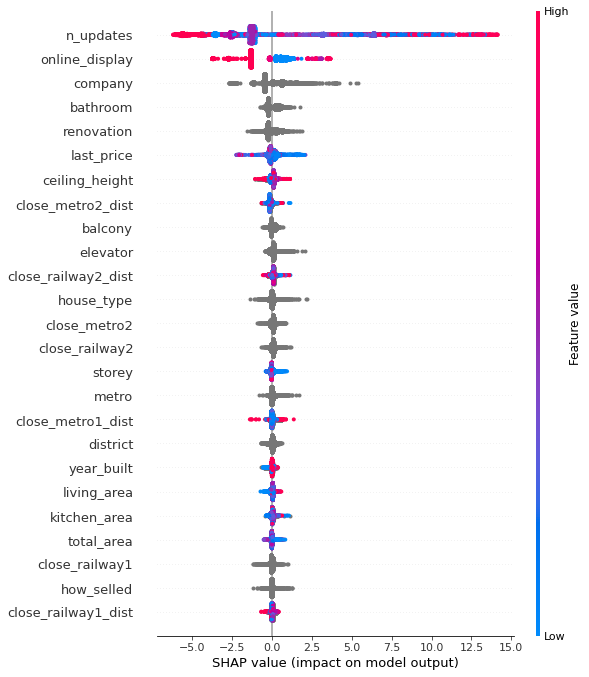

In [707]:
shap.summary_plot(shap_values, X_train, max_display = 25)